In [ ]:
from api.recs import *
from api.server_globals import sg
sg.init(app=None)

In [ ]:
from notebooks import *

In [ ]:
species = 'MGWA'

In [ ]:
from datasets import xc_meta_to_raw_recs, xc_raw_recs_to_recs
mgwa = (sg.xc_meta
    [lambda df: df.species == species]
    # [lambda df: df.quality.isin(['A', 'B'])]
    .sort_index(ascending=True)
    # .pipe(df_inspect, lambda df: (df.shape, df[:10]))
    # [:3]
    .pipe(xc_meta_to_raw_recs, load=sg.load)
    .pipe(xc_raw_recs_to_recs, projection=sg.projection)
    .pipe(df_inspect, lambda df: (df.shape, df[:3]))
)

In [ ]:

features = sg.features

def table_recs(
    recs,
    limit=None,
    more_cols=[],
    cols=xc_eda_cols,
    decorate=True,
    dist_bar_size=30,
    handtype_cmap=mpl_cmap_concat('tab10', 'tab20'),
    color_stack=False,
    **kwargs_recs_decorate,
):
    if decorate:
        recs = recs_decorate(recs, **kwargs_recs_decorate)
    return (recs
        .join(how='left', other=load_xc_handtype())
        .fillna({'handtype': ''})  # TODO TODO dev
        .pipe(df_col_map, handtype=lambda xs: [x[:3] for x in xs])
        .pipe(df_col_color_d, handtype=handtype_cmap, _stack=color_stack)
        [:limit]
        .pipe(lambda df: df if 'dist' not in df.columns else df_assign_first(df,
            dist_bar=lambda df: df.dist.map(lambda dist: text_bar(dist, max=df.dist.max(), norm=dist_bar_size, side='right')),
        ))
        .pipe(lambda df: df[[
            c
            for c in [
                'dist_bar', 'dist', 'handtype',
                'thumb', 'micro',
                *more_cols,
                *cols,
            ]
            if c in df.columns
        ]])
    )

def recs_decorate(
    recs,
    size='big',  # 'big' | 'small'
    thumb_s=2,
    micro_s=13,
):
    cols = dict()
    if size == 'big':
        cols.update(dict(
            thumb=df_cell_spectros(plot_thumb.many, features, thumb_s=thumb_s, scale=dict(h=26)),
            micro=df_cell_spectros(plot_spectro_micro.many, features, wrap_s=micro_s, scale=dict(h=26)),
        ))
    else:
        cols.update(dict(
            thumb=df_cell_spectros(plot_thumb.many, features, thumb_s=thumb_s, scale=dict(h=13)),
            micro=df_cell_spectros(plot_spectro_micro.many, features, wrap_s=micro_s*2, scale=dict(h=13)),  # HACK micro_s*2
        ))
    return df_assign_first(recs, **cols)

In [ ]:
display(
    len(mgwa),
    mgwa.quality.value_counts().sort_index(),
)

168

A           69
B           71
C           14
D            3
E            1
no score    10
Name: quality, dtype: int64

,xc_id,duration_s,micro,remarks_stack,type_stack,handtype,species,subspecies,quality,state,lat,lng,year,month_day,hour,time,license_type,recordist,elevation,bird_seen,playback_used,background_species
0,391884,28.2,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",Recording unmodified.,"call, female",,MGWA,,A,"Chiapas, Mexico",16.8,-93.5,2017,10-30,7.0,07:00,by-nc-sa,Nick Komar,850 m,yes,no,[]
1,332710,12.4,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",A migrant in female/juvenile plumage calling from low riparian vegetation. Recording filtered for clarity.,call,,MGWA,,B,"Colorado, United States",40.6,-105.0,2016,08-24,7.0,07:30,by-nc-sa,Nick Komar,1600 m,yes,no,[]
2,256187,78.3,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",This bird was calling and foraging in a dense stand of mountain mahogany about 4-8ft off the ground and about5-15ft from me. No playback was used but I did pish her in initially to make a positive ID.,"call, female",,MGWA,,B,"Nevada, United States",38.9,-117.0,2015,07-07,10.0,10:00,by-nc-sa,Bobby Wilcox,2600 m,yes,no,[]
3,158382,14.5,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",Calling from dense vegetation along the Rio Cuchujaqui.,"call, female",,MGWA,,B,"Sonora, Mexico",27.0,-109.0,2013,12-18,16.0,16:30,by-nc-sa,Micah Riegner,320 m,yes,no,[]
4,102804,9.89,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",natural vocalization from two birds chasing each other; Ibelieve the female is giving the actual calls. A few flight calls followed by a few contact calls.,flight call and call,,MGWA,,A,"Colorado, United States",39.7,-108.0,2012,05-31,8.0,08:00,by-nc-nd,Andrew Spencer,2400 m,None,None,[]

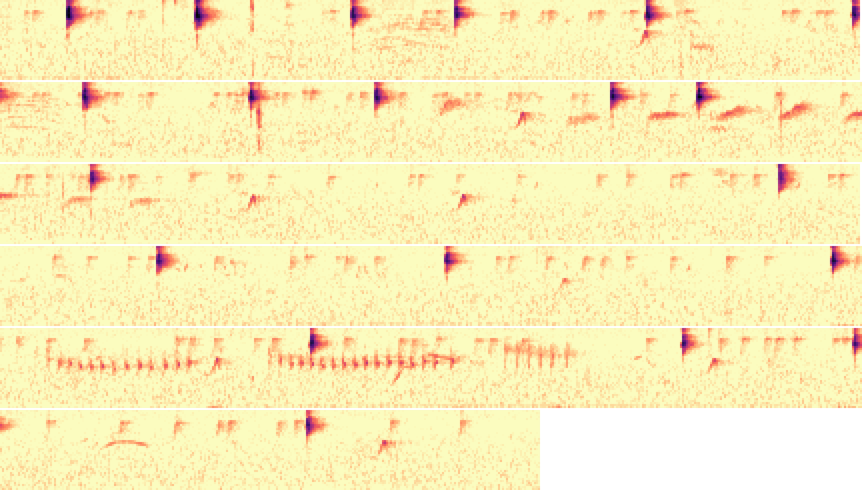
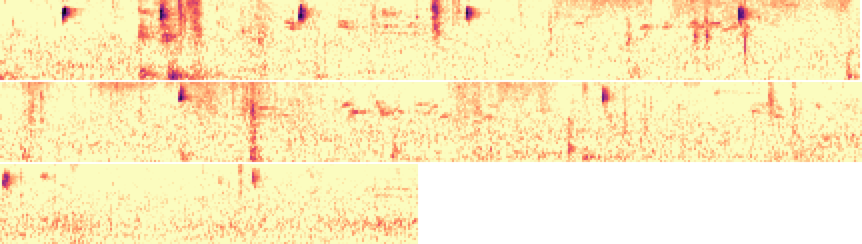
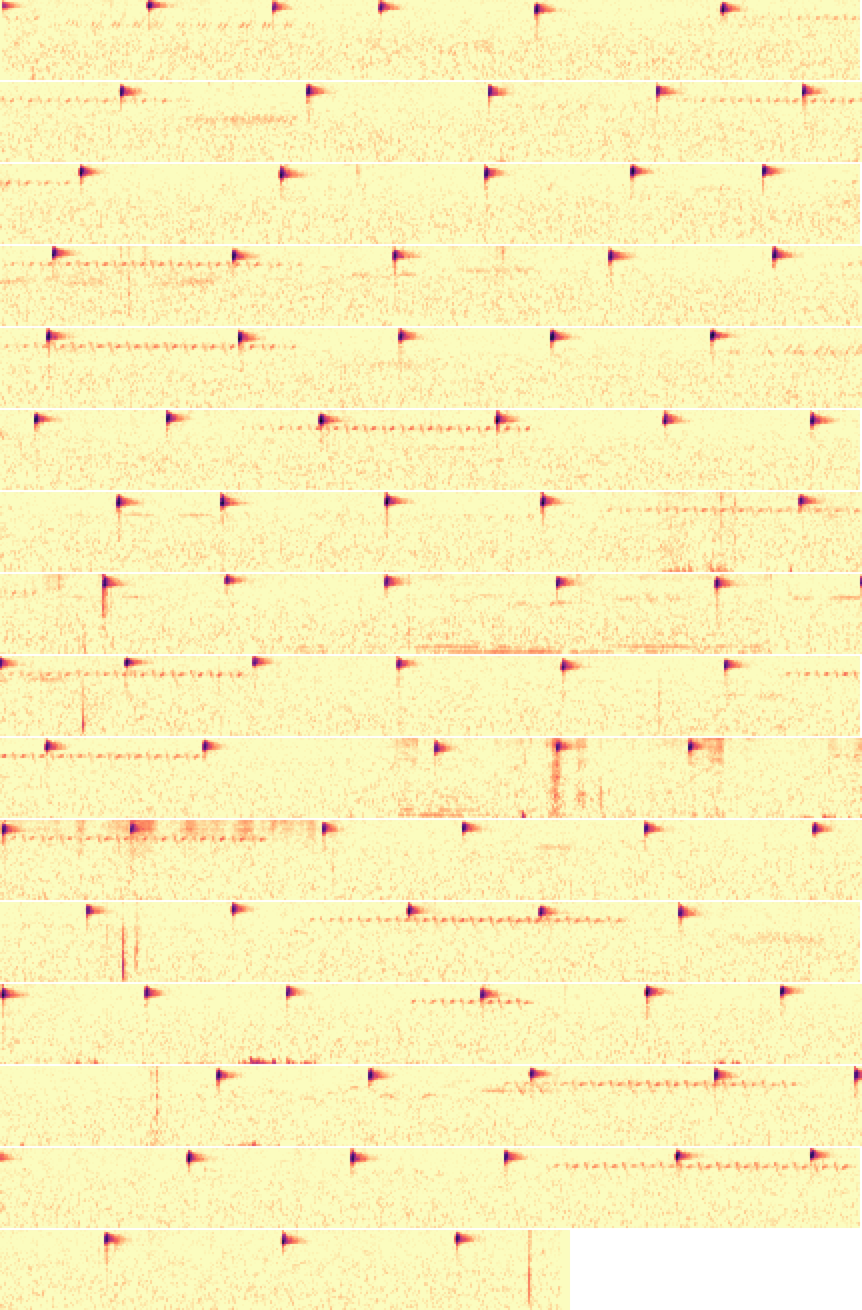
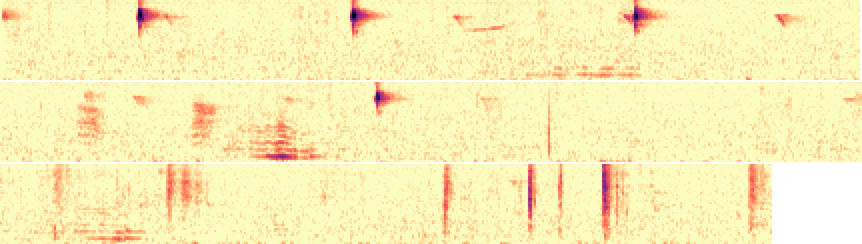
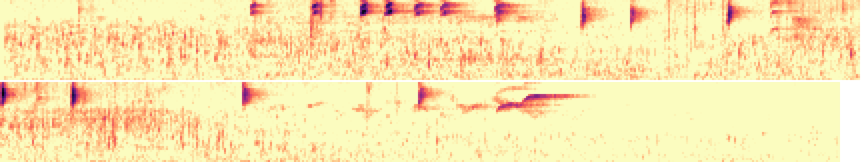

In [ ]:
(mgwa
    [lambda df: df_map_rows(df, lambda row: 'female' in str(row).lower())]
    .assign(
        # micro=df_cell_spectros(plot_spectro_micro.many, features, wrap_s=20, scale=dict(h=26)),
        micro=df_cell_spectros(plot_spectro_wrap.many, features, wrap_s=5,
            scale=2,
            # scale=dict(h=26),
        ),
    )
    .pipe(table_recs,
        # size='big',
        # limit=20,
        more_cols=['remarks_stack'],
        decorate=False,
    )
    .assign(
        remarks_stack=df_cell_textwrap('remarks', 60),
        type_stack=df_cell_textwrap('type', 40),
    )
    .pipe(df_reorder_cols, first=['duration_s', 'micro', 'remarks_stack', 'type_stack', ])
    .drop(columns=['remarks', 'type'])
    .sort_index(ascending=False)
    .reset_index()
)